In [ ]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import time
import math
import scipy.stats as stats
import itertools

In [ ]:
# Load AKSI stock dataset
df_aksi = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='AKSI.JK')
df_aksi.set_index('Date', drop=True, inplace=True)
df_aksi.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-04,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-05,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-06,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-07,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0


In [ ]:
# Check datatypes
print(df_aksi.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [ ]:
# Check missing value
print(df_aksi.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [ ]:
# Fill missing value using mean imputation
for i in df_aksi[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_aksi[i].fillna(df_aksi[i].mean(), inplace=True)

print(df_aksi.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


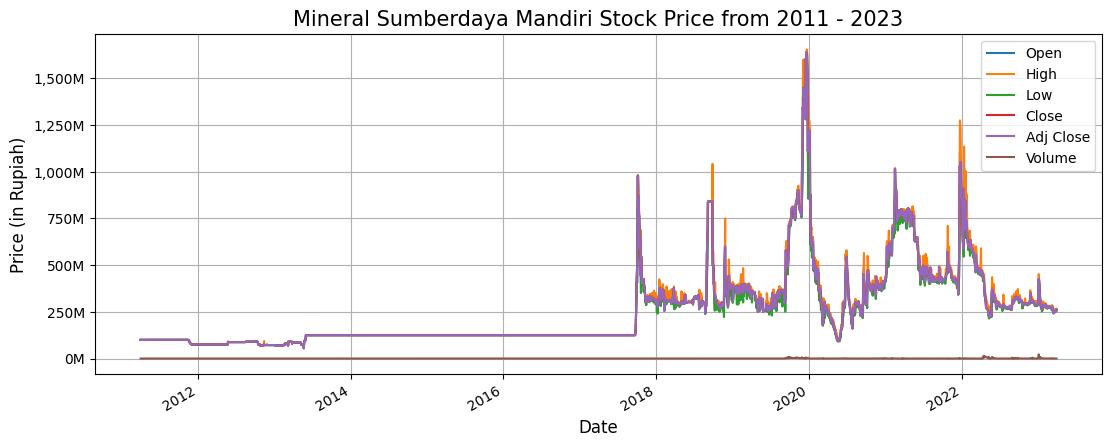

In [ ]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_aksi.plot(figsize=(13,5))
plt.title('Mineral Sumberdaya Mandiri Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

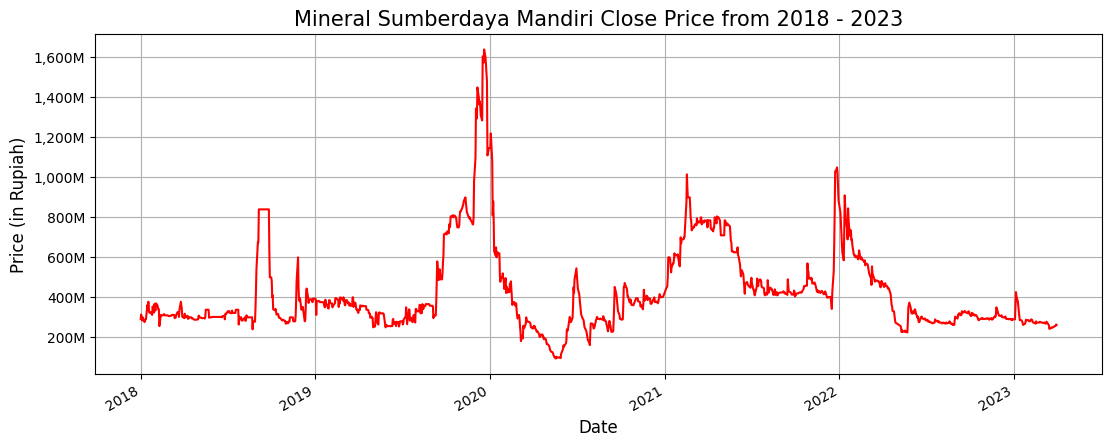

In [ ]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_aksi['Close']['2018':].plot(figsize=(13,5), color='red')
plt.title('Mineral Sumberdaya Mandiri Close Price from 2018 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [ ]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_aksi[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [ ]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]] 

Testing Scaled:  [[0.43217666]
 [0.40063091]
 [0.49842271]
 [0.4637224 ]
 [0.44164038]]


In [ ]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
start_time=time.time()
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 4s 55ms/step - loss: 0.0096 - val_loss: 0.0066
Epoch 2/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 3/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 4/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 5/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 1s 26ms/step - loss: 9.7184e-04 - val_loss: 0.0023
Epoch 9/10
24/24 [==============================] - 1s 27ms/step - loss: 8.6300e-04 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 1s 26ms/step - loss: 8.2453e-04 - val_loss: 0.00

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 1s 7ms/step
Mean Absolute Error (MAE): 0.0163718
Mean Absolute Percentage Error (MAPE): 0.1101
Root Mean Squared Error (RMSE): 0.01998
Mean Squared Error (MSE): 0.0003994
R-Squared (R2): 0.023467
T-Statistic 0.8603
P-Value 6.75197338361258e-14
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 8ms/step


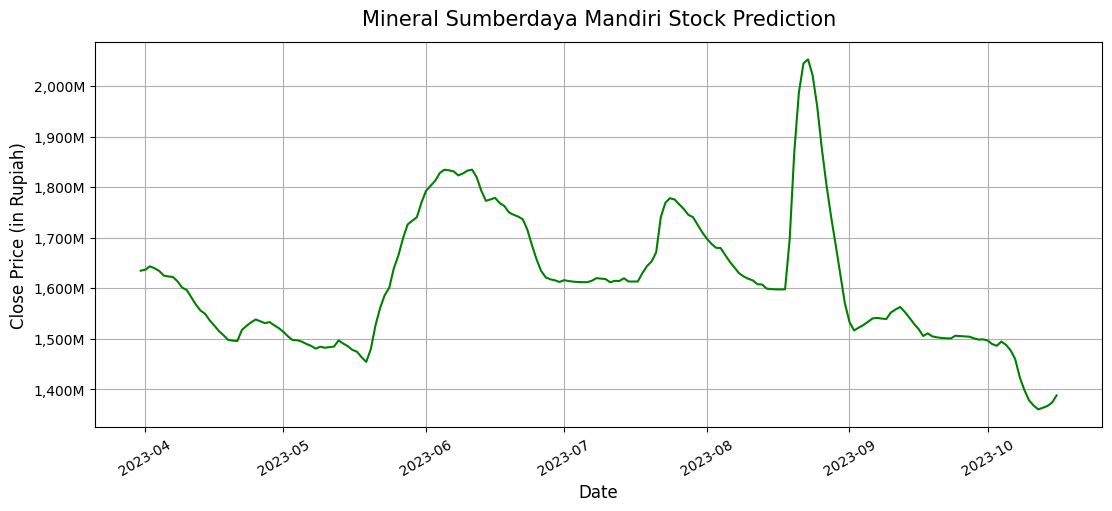

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 13s 273ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 2/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 3/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 5/10
24/24 [==============================] - 6s 258ms/step - loss: 9.8750e-04 - val_loss: 0.0042
Epoch 6/10
24/24 [==============================] - 6s 271ms/step - loss: 9.4722e-04 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 6s 257ms/step - loss: 8.5331e-04 - val_loss: 0.0023
Epoch 8/10
24/24 [==============================] - 6s 255ms/step - loss: 9.9090e-04 - val_loss: 0.0025
Epoch 9/10
24/24 [==============================] - 6s 254ms/step - loss: 8.5170e-04 - val_loss: 0.0040
Epoch 10/10
24/24 [==============================] - 6s 267ms/step - loss: 8.18

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0079835
Mean Absolute Percentage Error (MAPE): 0.05008
Root Mean Squared Error (RMSE): 0.01414
Mean Squared Error (MSE): 0.0001999
R-Squared (R2): 0.511213
T-Statistic 0.8819
P-Value 1.182429046168998e-12
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 34ms/step


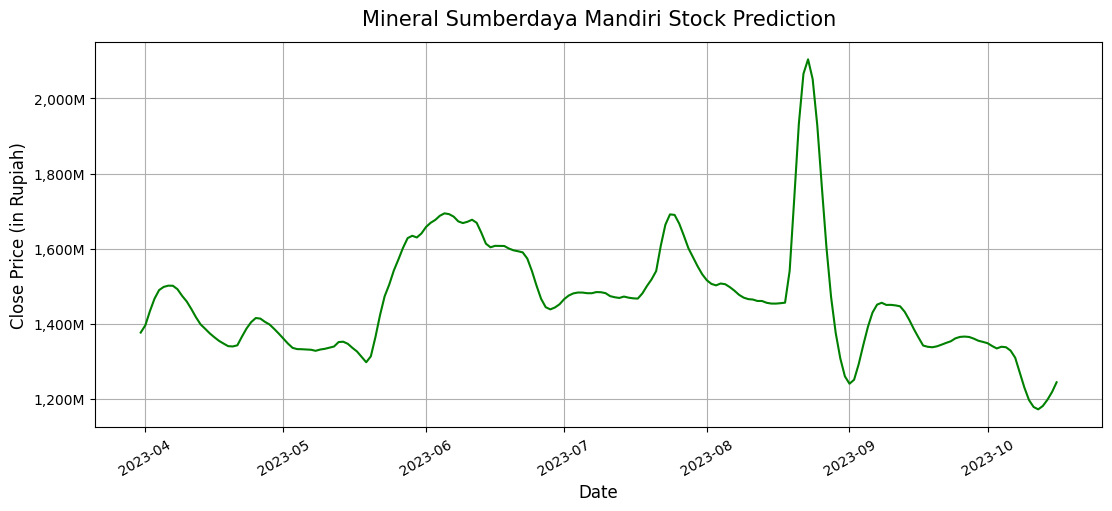

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 14s 332ms/step - loss: 0.0199 - val_loss: 0.0836
Epoch 2/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0156 - val_loss: 0.0696
Epoch 3/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0144 - val_loss: 0.0635
Epoch 4/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0141 - val_loss: 0.0604
Epoch 5/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0139 - val_loss: 0.0584
Epoch 6/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0135 - val_loss: 0.0571
Epoch 7/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0132 - val_loss: 0.0555
Epoch 8/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0131 - val_loss: 0.0546
Epoch 9/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0128 - val_loss: 0.0540
Epoch 10/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0128 - val_loss: 0.052

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.0453429
Mean Absolute Percentage Error (MAPE): 0.29082
Root Mean Squared Error (RMSE): 0.04932
Mean Squared Error (MSE): 0.0024329
R-Squared (R2): -4.948515
T-Statistic 0.718
P-Value 8.444993188874446e-20
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 39ms/step


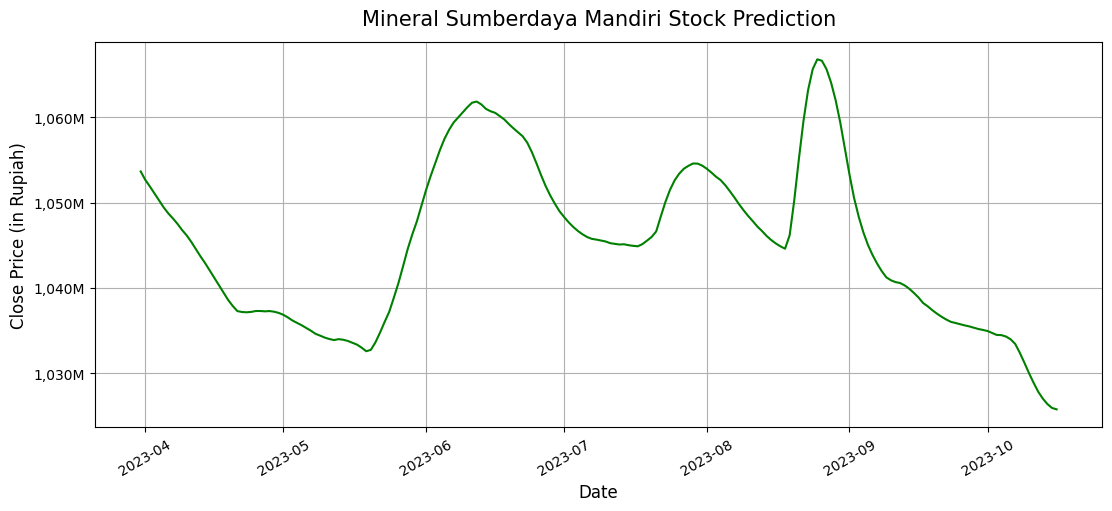

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 18s 322ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 2/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 3/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 7s 287ms/step - loss: 9.2220e-04 - val_loss: 0.0039
Epoch 7/10
24/24 [==============================] - 7s 296ms/step - loss: 8.7481e-04 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 7s 289ms/step - loss: 9.1644e-04 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 7s 290ms/step - loss: 8.5398e-04 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 7s 281ms/step - loss: 8.1118e-

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0092249
Mean Absolute Percentage Error (MAPE): 0.05905
Root Mean Squared Error (RMSE): 0.015
Mean Squared Error (MSE): 0.0002251
R-Squared (R2): 0.449648
T-Statistic 0.8844
P-Value 1.6742072138364872e-12
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 45ms/step


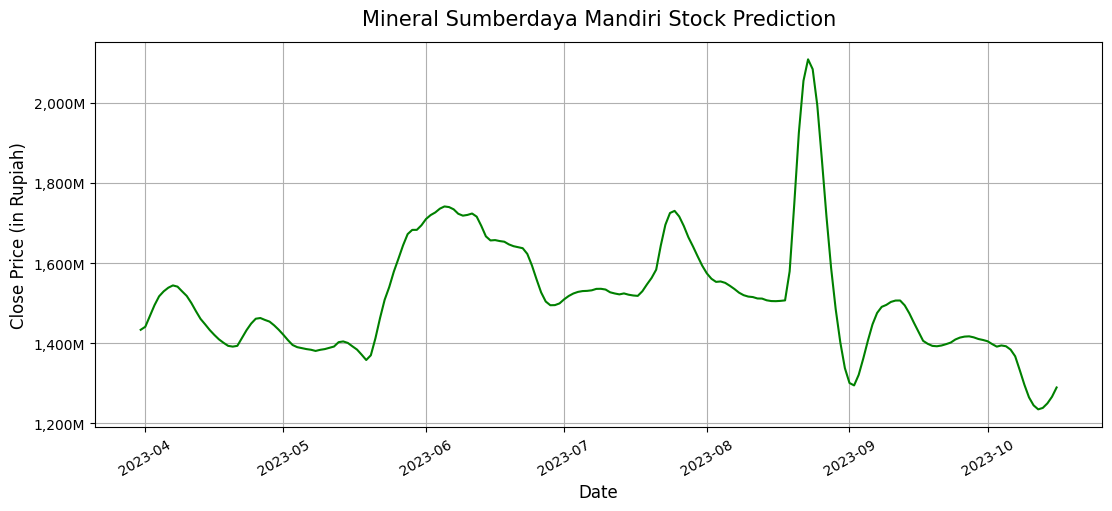

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 14s 287ms/step - loss: 0.0045 - val_loss: 0.0074
Epoch 2/10
24/24 [==============================] - 5s 200ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 3/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 5s 216ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 6/10
24/24 [==============================] - 5s 209ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 7/10
24/24 [==============================] - 5s 200ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 8/10
24/24 [==============================] - 5s 198ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 9/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 5s 204ms/step - loss: 0.0015 - val_loss: 0.002

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 0.011844
Mean Absolute Percentage Error (MAPE): 0.0775
Root Mean Squared Error (RMSE): 0.01779
Mean Squared Error (MSE): 0.0003166
R-Squared (R2): 0.225845
T-Statistic 0.8754
P-Value 4.773543214355025e-13
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 43ms/step


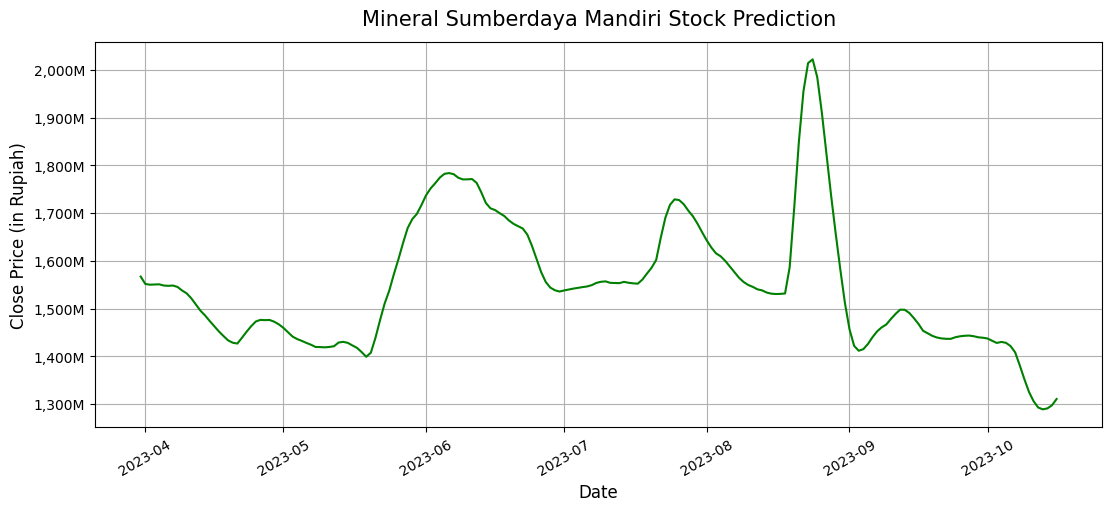

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 15s 322ms/step - loss: 0.0217 - val_loss: 0.1030
Epoch 2/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0215 - val_loss: 0.1012
Epoch 3/10
24/24 [==============================] - 5s 226ms/step - loss: 0.0211 - val_loss: 0.0994
Epoch 4/10
24/24 [==============================] - 5s 219ms/step - loss: 0.0203 - val_loss: 0.0976
Epoch 5/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0201 - val_loss: 0.0959
Epoch 6/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0195 - val_loss: 0.0942
Epoch 7/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0190 - val_loss: 0.0924
Epoch 8/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0186 - val_loss: 0.0908
Epoch 9/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0185 - val_loss: 0.0891
Epoch 10/10
24/24 [==============================] - 6s 241ms/step - loss: 0.0179 - val_loss: 0.087

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.1203681
Mean Absolute Percentage Error (MAPE): 0.7987
Root Mean Squared Error (RMSE): 0.12187
Mean Squared Error (MSE): 0.0148532
R-Squared (R2): -35.316061
T-Statistic 0.7683
P-Value 4.899029290223897e-18
Elapsed Time (min): 9.8
Skew distribution


In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 14s 320ms/step - loss: 0.0209 - val_loss: 0.0767
Epoch 2/10
24/24 [==============================] - 5s 215ms/step - loss: 0.0174 - val_loss: 0.0729
Epoch 3/10
24/24 [==============================] - 5s 210ms/step - loss: 0.0166 - val_loss: 0.0688
Epoch 4/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0155 - val_loss: 0.0659
Epoch 5/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0147 - val_loss: 0.0585
Epoch 6/10
24/24 [==============================] - 5s 230ms/step - loss: 0.0140 - val_loss: 0.0573
Epoch 7/10
24/24 [==============================] - 6s 241ms/step - loss: 0.0132 - val_loss: 0.0531
Epoch 8/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0125 - val_loss: 0.0510
Epoch 9/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0114 - val_loss: 0.0473
Epoch 10/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0111 - val_loss: 0.045

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0429185
Mean Absolute Percentage Error (MAPE): 0.27508
Root Mean Squared Error (RMSE): 0.04686
Mean Squared Error (MSE): 0.0021954
R-Squared (R2): -4.367846
T-Statistic 0.7198
P-Value 9.684279060010513e-20
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 38ms/step


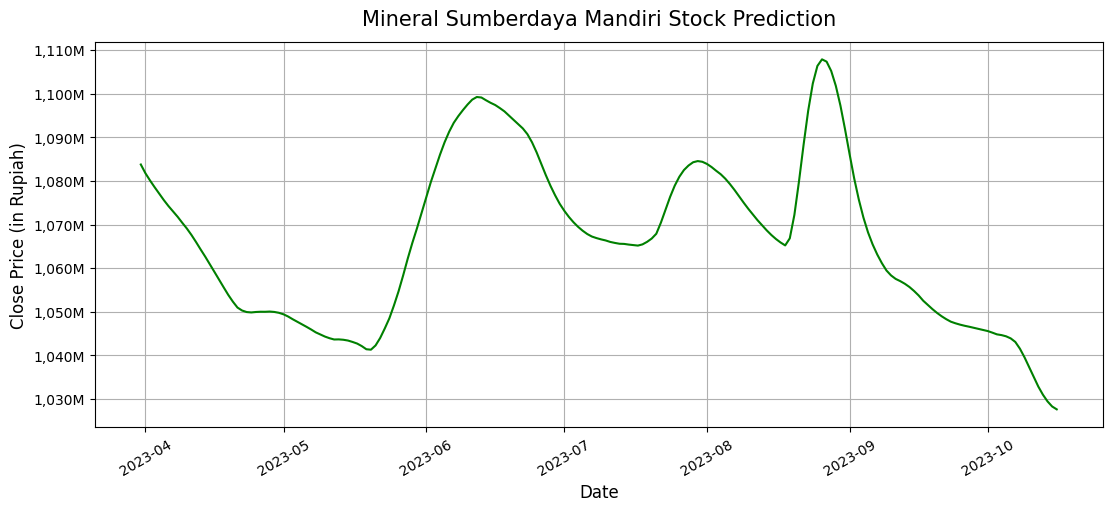

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 16s 318ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 2/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0022 - val_loss: 0.0042
Epoch 3/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 5/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 6/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 7/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 8/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0010 - val_loss: 0.003

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 0.009868
Mean Absolute Percentage Error (MAPE): 0.06317
Root Mean Squared Error (RMSE): 0.01741
Mean Squared Error (MSE): 0.0003031
R-Squared (R2): 0.25888
T-Statistic 0.8764
P-Value 5.515070279800416e-13
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 33ms/step


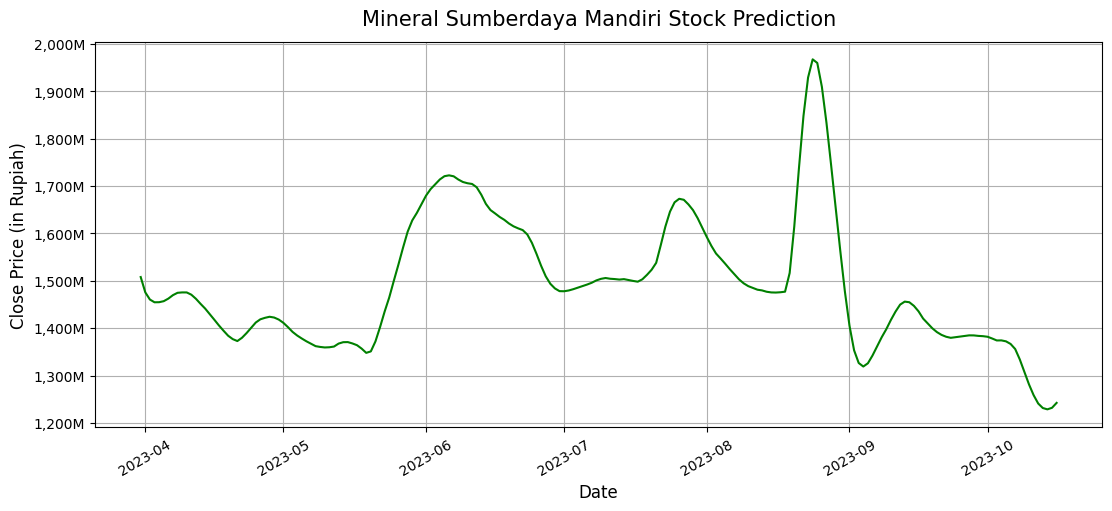

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 14s 296ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 2/10
24/24 [==============================] - 5s 211ms/step - loss: 0.0018 - val_loss: 0.0081
Epoch 3/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 4/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 6s 239ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 6/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0010 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 5s 224ms/step - loss: 8.9524e-04 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 6s 256ms/step - loss: 9.1686e-04 - val_los

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0125086
Mean Absolute Percentage Error (MAPE): 0.0817
Root Mean Squared Error (RMSE): 0.01755
Mean Squared Error (MSE): 0.0003079
R-Squared (R2): 0.247172
T-Statistic 0.8787
P-Value 7.54146636632036e-13
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 32ms/step


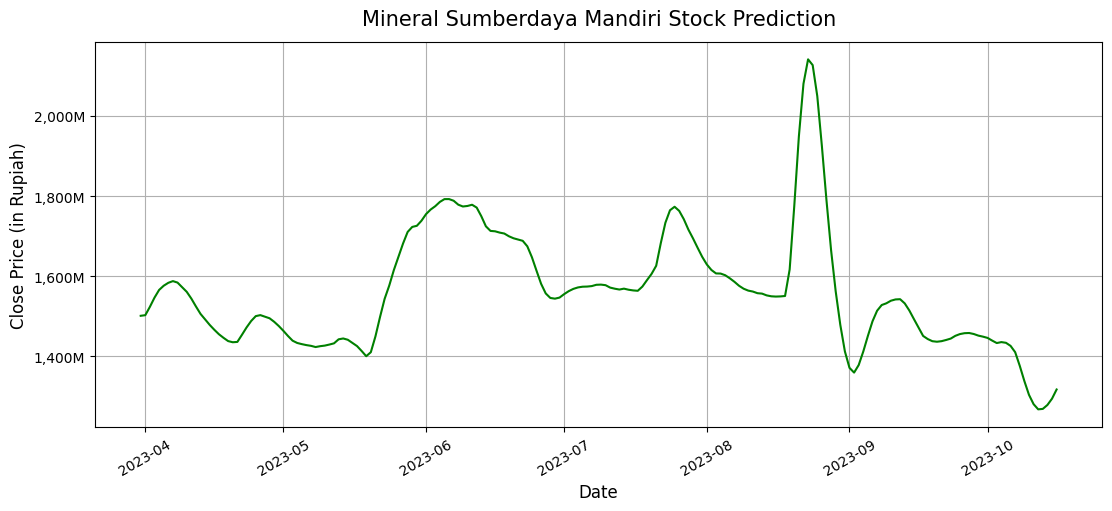

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 16s 352ms/step - loss: 0.0228 - val_loss: 0.0980
Epoch 2/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0177 - val_loss: 0.0811
Epoch 3/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0157 - val_loss: 0.0713
Epoch 4/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0149 - val_loss: 0.0654
Epoch 5/10
24/24 [==============================] - 6s 272ms/step - loss: 0.0143 - val_loss: 0.0617
Epoch 6/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0138 - val_loss: 0.0589
Epoch 7/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0136 - val_loss: 0.0566
Epoch 8/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0135 - val_loss: 0.0549
Epoch 9/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0132 - val_loss: 0.0535
Epoch 10/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0129 - val_loss: 0.052

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 0.0451593
Mean Absolute Percentage Error (MAPE): 0.28956
Root Mean Squared Error (RMSE): 0.04917
Mean Squared Error (MSE): 0.0024178
R-Squared (R2): -4.911444
T-Statistic 0.6579
P-Value 1.2646180956419513e-21
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 35ms/step


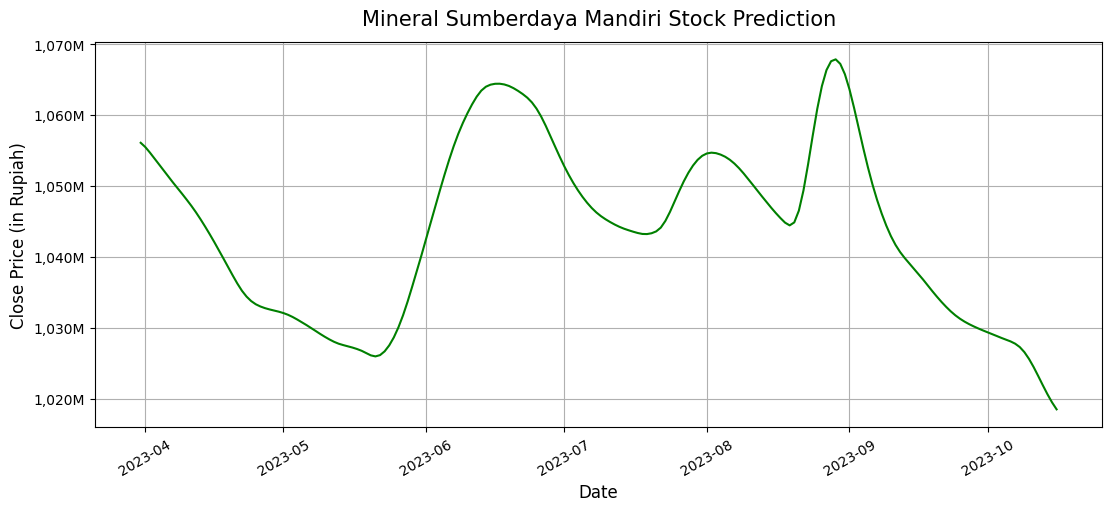

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 15s 283ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 2/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 3/10
24/24 [==============================] - 5s 222ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 5s 218ms/step - loss: 0.0012 - val_loss: 0.0037
Epoch 5/10
24/24 [==============================] - 6s 237ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 5s 215ms/step - loss: 9.1335e-04 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 5s 225ms/step - loss: 9.6711e-04 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 5s 210ms/step - loss: 9.5356e-04 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 5s 205ms/step - loss: 9.3276e-04 - val_loss: 0.0027
Epoch 10/10
24/24 [==============================] - 5s 226ms/step - loss: 9.2552e-

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 31ms/step
Mean Absolute Error (MAE): 0.009272
Mean Absolute Percentage Error (MAPE): 0.05863
Root Mean Squared Error (RMSE): 0.01515
Mean Squared Error (MSE): 0.0002294
R-Squared (R2): 0.439226
T-Statistic 0.8902
P-Value 3.8791600140419824e-12
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 31ms/step


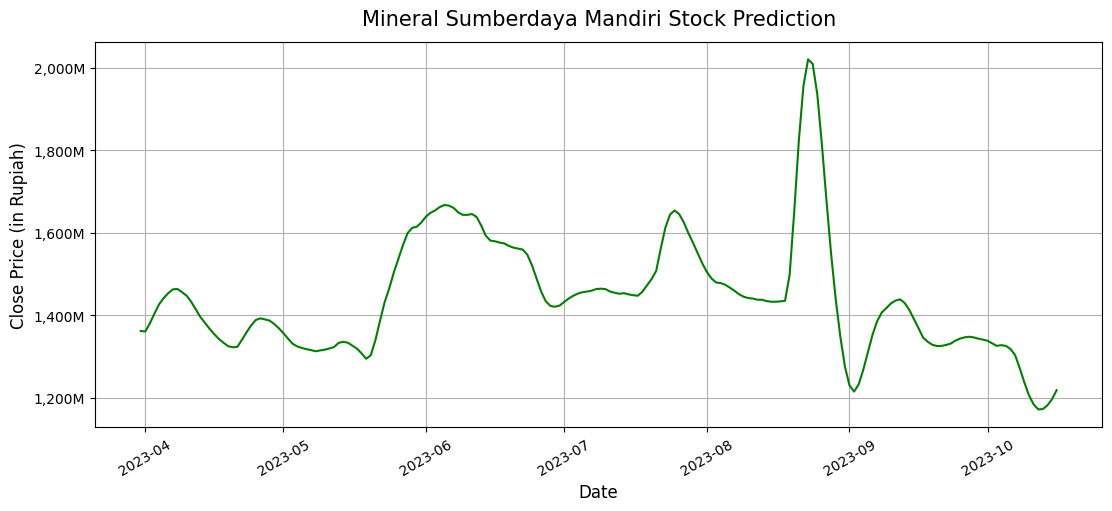

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 15s 332ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 2/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0028 - val_loss: 0.0165
Epoch 3/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 4/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 6s 244ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 6/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 7/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 8/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 10/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0012 - val_loss: 0.006

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 37ms/step
Mean Absolute Error (MAE): 0.0366346
Mean Absolute Percentage Error (MAPE): 0.243
Root Mean Squared Error (RMSE): 0.03987
Mean Squared Error (MSE): 0.0015893
R-Squared (R2): -2.885897
T-Statistic 0.8823
P-Value 1.2521545215624097e-12
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 33ms/step


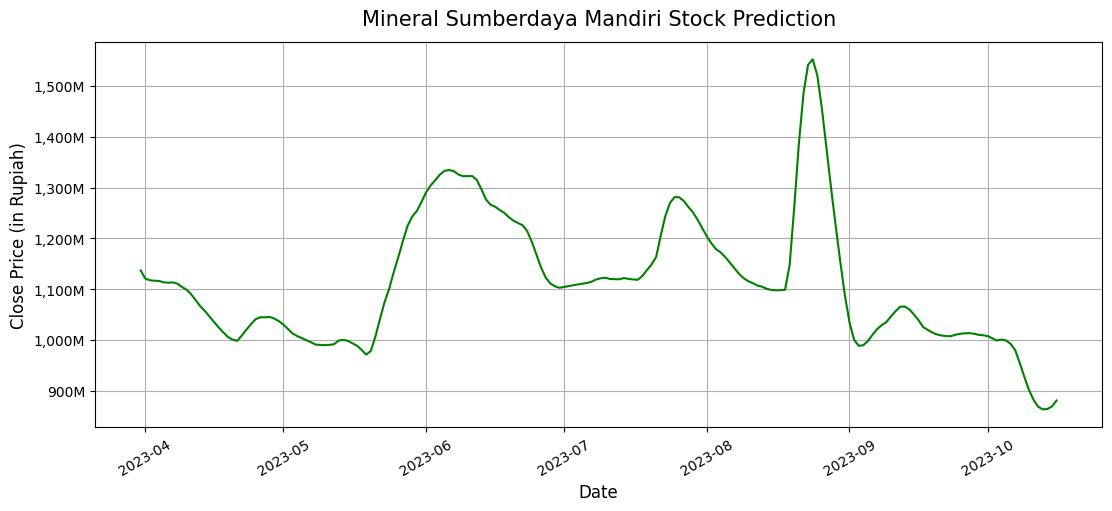

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 15s 321ms/step - loss: 0.0257 - val_loss: 0.1230
Epoch 2/10
24/24 [==============================] - 6s 241ms/step - loss: 0.0255 - val_loss: 0.1220
Epoch 3/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0253 - val_loss: 0.1210
Epoch 4/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0251 - val_loss: 0.1200
Epoch 5/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0249 - val_loss: 0.1191
Epoch 6/10
24/24 [==============================] - 6s 244ms/step - loss: 0.0246 - val_loss: 0.1181
Epoch 7/10
24/24 [==============================] - 6s 241ms/step - loss: 0.0245 - val_loss: 0.1172
Epoch 8/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0240 - val_loss: 0.1162
Epoch 9/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0237 - val_loss: 0.1153
Epoch 10/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0234 - val_loss: 0.114

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 31ms/step
Mean Absolute Error (MAE): 0.142138
Mean Absolute Percentage Error (MAPE): 0.94474
Root Mean Squared Error (RMSE): 0.14361
Mean Squared Error (MSE): 0.0206248
R-Squared (R2): -49.427834
T-Statistic 0.94
P-Value 2.6433140121184806e-08
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 33ms/step


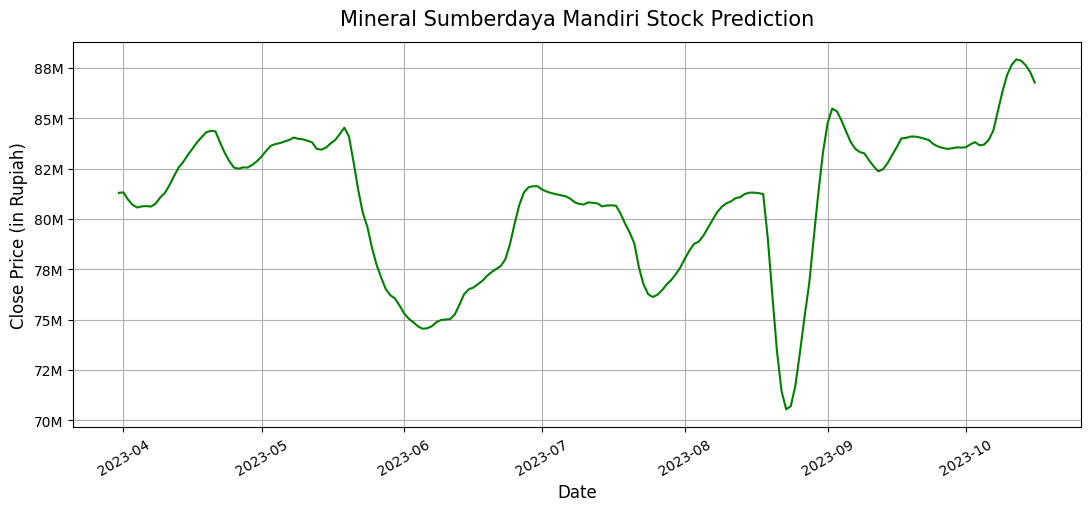

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 16s 344ms/step - loss: 0.0221 - val_loss: 0.0885
Epoch 2/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0163 - val_loss: 0.0705
Epoch 3/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0147 - val_loss: 0.0631
Epoch 4/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0139 - val_loss: 0.0582
Epoch 5/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0133 - val_loss: 0.0548
Epoch 6/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0130 - val_loss: 0.0524
Epoch 7/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0125 - val_loss: 0.0499
Epoch 8/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0123 - val_loss: 0.0488
Epoch 9/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0118 - val_loss: 0.0476
Epoch 10/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0117 - val_loss: 0.046

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 35ms/step
Mean Absolute Error (MAE): 0.0458638
Mean Absolute Percentage Error (MAPE): 0.29494
Root Mean Squared Error (RMSE): 0.04958
Mean Squared Error (MSE): 0.0024581
R-Squared (R2): -5.009981
T-Statistic 0.6966
P-Value 1.764248453633317e-20
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 34ms/step


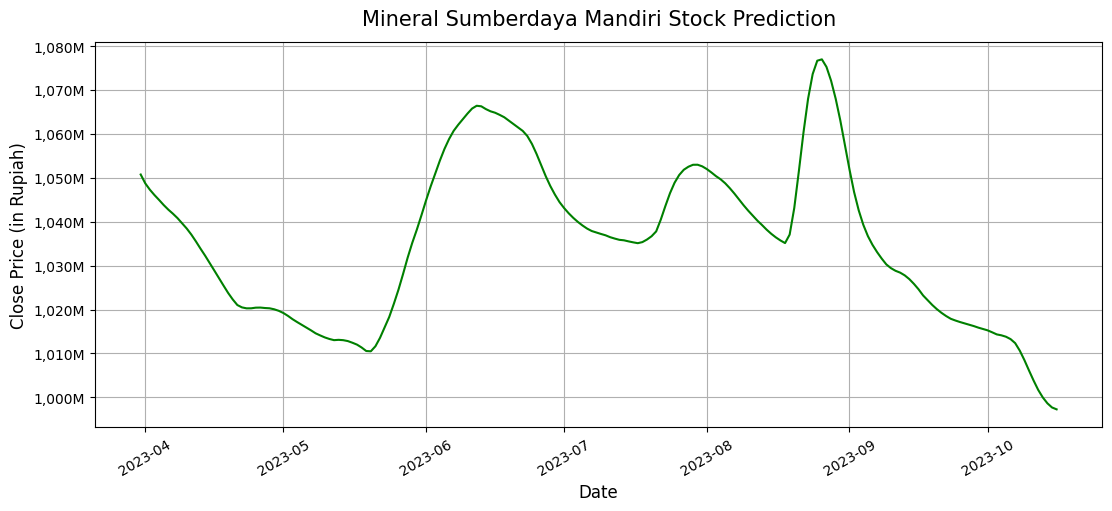

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 308ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 2/10
24/24 [==============================] - 6s 235ms/step - loss: 0.0029 - val_loss: 0.0064
Epoch 3/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 4/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 5/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 8/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 9/10
24/24 [==============================] - 6s 262ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 10/10
24/24 [==============================] - 6s 270ms/step - loss: 0.0012 - val_loss: 0.003

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.0146282
Mean Absolute Percentage Error (MAPE): 0.09648
Root Mean Squared Error (RMSE): 0.02127
Mean Squared Error (MSE): 0.0004526
R-Squared (R2): -0.106497
T-Statistic 0.8627
P-Value 9.067266116538283e-14
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 36ms/step


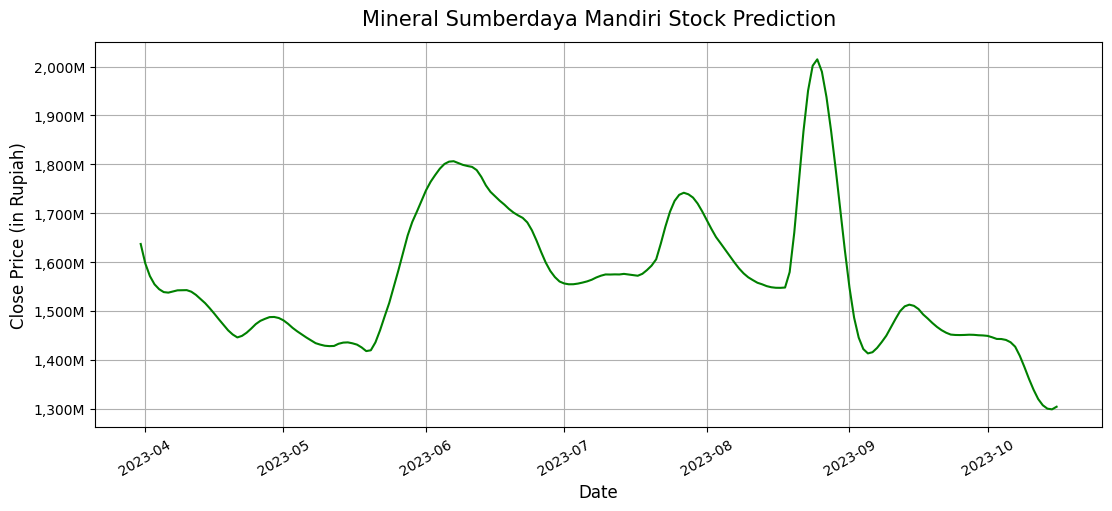

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 16s 325ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 2/10
24/24 [==============================] - 6s 256ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 3/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 4/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 6/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 6s 259ms/step - loss: 8.4835e-04 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 6s 265ms/step - loss: 9.0667e-04 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 7s 296ms/step - loss: 8.3928e-04 - val

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.0083972
Mean Absolute Percentage Error (MAPE): 0.05292
Root Mean Squared Error (RMSE): 0.01486
Mean Squared Error (MSE): 0.0002208
R-Squared (R2): 0.4602
T-Statistic 0.8849
P-Value 1.8005812769603113e-12
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 32ms/step


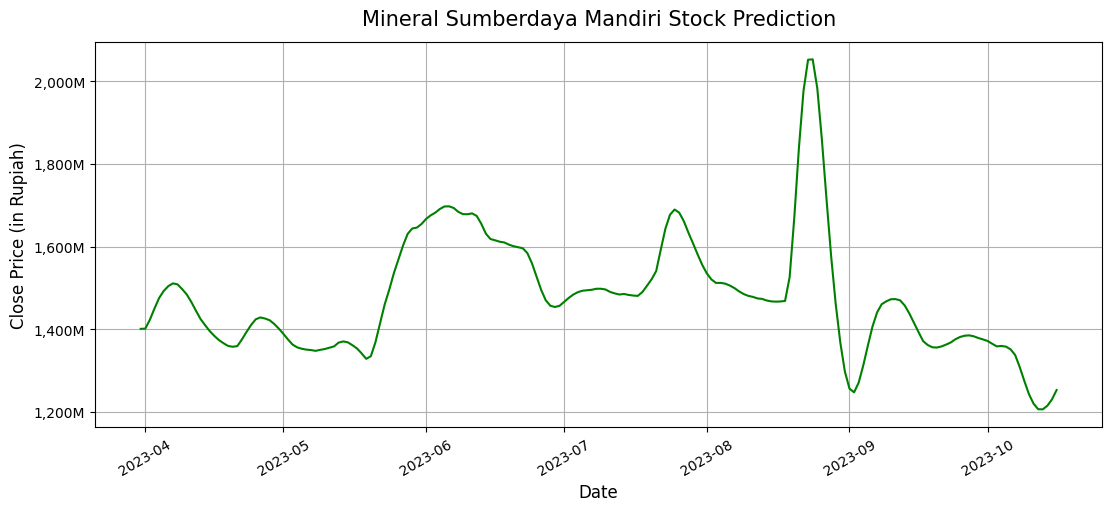

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 13s 293ms/step - loss: 0.5323 - val_loss: 0.1805
Epoch 2/10
24/24 [==============================] - 6s 237ms/step - loss: 0.3802 - val_loss: 0.1181
Epoch 3/10
24/24 [==============================] - 6s 260ms/step - loss: 0.2977 - val_loss: 0.0808
Epoch 4/10
24/24 [==============================] - 6s 252ms/step - loss: 0.2405 - val_loss: 0.0560
Epoch 5/10
24/24 [==============================] - 6s 241ms/step - loss: 0.1972 - val_loss: 0.0391
Epoch 6/10
24/24 [==============================] - 7s 280ms/step - loss: 0.1630 - val_loss: 0.0276
Epoch 7/10
24/24 [==============================] - 6s 246ms/step - loss: 0.1361 - val_loss: 0.0199
Epoch 8/10
24/24 [==============================] - 6s 263ms/step - loss: 0.1135 - val_loss: 0.0151
Epoch 9/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0958 - val_loss: 0.0126
Epoch 10/10
24/24 [==============================] - 7s 271ms/step - loss: 0.0804 - val_loss: 0.011

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 35ms/step
Mean Absolute Error (MAE): 0.1864569
Mean Absolute Percentage Error (MAPE): 1.27842
Root Mean Squared Error (RMSE): 0.18761
Mean Squared Error (MSE): 0.0351989
R-Squared (R2): -85.061385
T-Statistic 0.7393
P-Value 4.389169222716624e-19
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 32ms/step


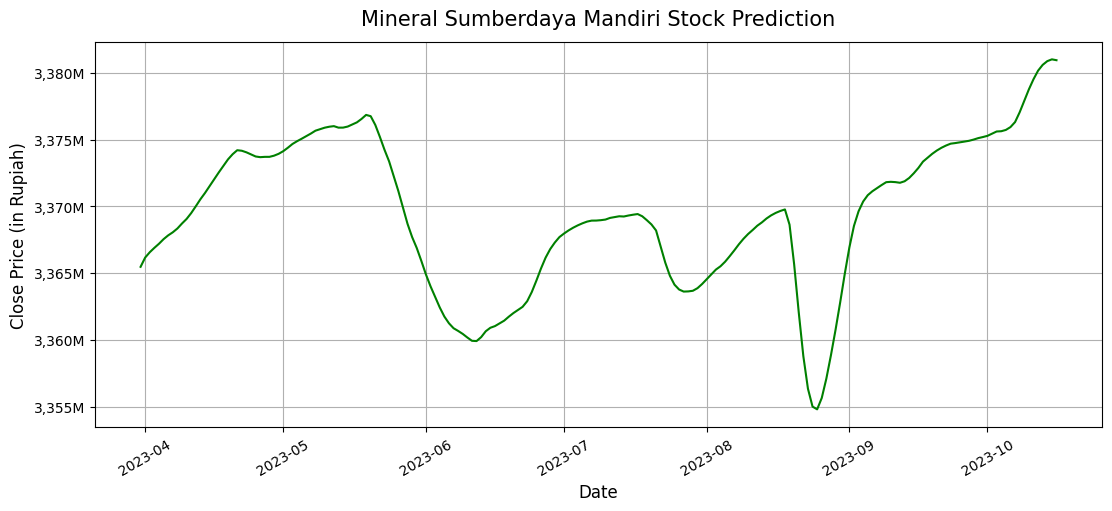

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 17s 336ms/step - loss: 0.0133 - val_loss: 0.0071
Epoch 2/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 3/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 4/10
24/24 [==============================] - 7s 297ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 5/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 6/10
24/24 [==============================] - 7s 278ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 7/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 8/10
24/24 [==============================] - 7s 287ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 9/10
24/24 [==============================] - 7s 281ms/step - loss: 9.0380e-04 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0010 - val_loss: 0

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.0098496
Mean Absolute Percentage Error (MAPE): 0.0626
Root Mean Squared Error (RMSE): 0.01693
Mean Squared Error (MSE): 0.0002865
R-Squared (R2): 0.299582
T-Statistic 0.847
P-Value 1.340681461925149e-14
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 35ms/step


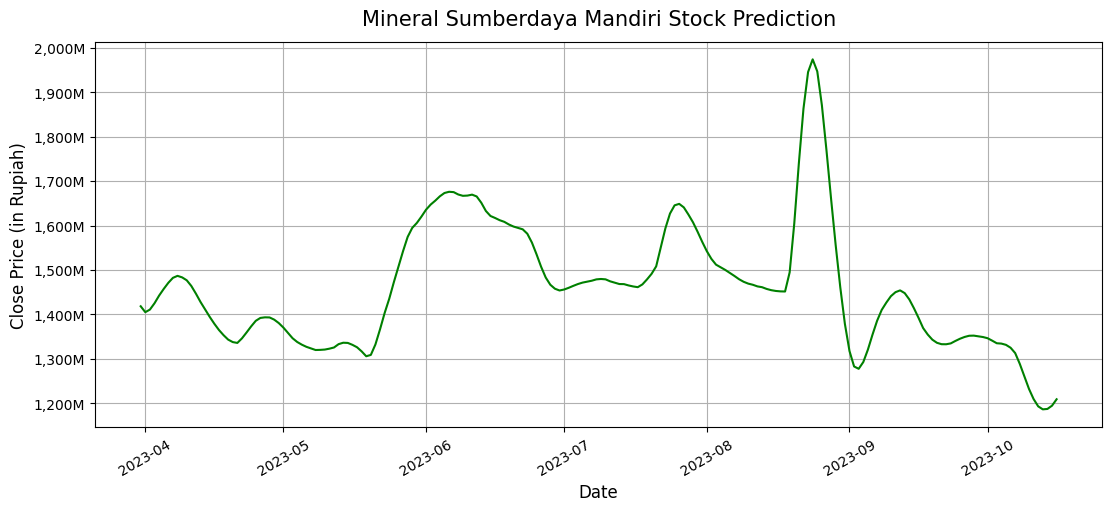

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 14s 322ms/step - loss: 0.0856 - val_loss: 0.0698
Epoch 2/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0174 - val_loss: 0.0080
Epoch 3/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0137 - val_loss: 0.0561
Epoch 4/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0111 - val_loss: 0.0127
Epoch 5/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0078 - val_loss: 0.0106
Epoch 6/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 7/10
24/24 [==============================] - 6s 249ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 8/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 9/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 10/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0031 - val_loss: 0.004

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.0146942
Mean Absolute Percentage Error (MAPE): 0.09893
Root Mean Squared Error (RMSE): 0.0227
Mean Squared Error (MSE): 0.0005152
R-Squared (R2): -0.259738
T-Statistic 0.7507
P-Value 1.1067655916444196e-18
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 35ms/step


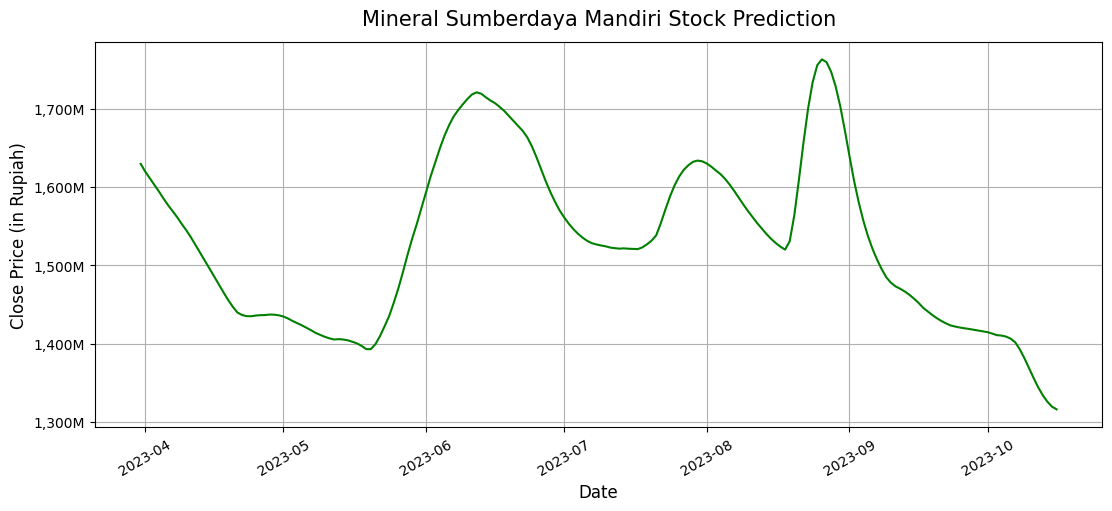

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 17s 335ms/step - loss: 0.0570 - val_loss: 0.0110
Epoch 2/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0566 - val_loss: 0.0110
Epoch 3/10
24/24 [==============================] - 6s 272ms/step - loss: 0.0562 - val_loss: 0.0111
Epoch 4/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0558 - val_loss: 0.0111
Epoch 5/10
24/24 [==============================] - 6s 272ms/step - loss: 0.0555 - val_loss: 0.0111
Epoch 6/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0550 - val_loss: 0.0112
Epoch 7/10
24/24 [==============================] - 6s 266ms/step - loss: 0.0547 - val_loss: 0.0112
Epoch 8/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0543 - val_loss: 0.0113
Epoch 9/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0539 - val_loss: 0.0113
Epoch 10/10
24/24 [==============================] - 7s 288ms/step - loss: 0.0534 - val_loss: 0.011

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.1484291
Mean Absolute Percentage Error (MAPE): 1.02059
Root Mean Squared Error (RMSE): 0.14977
Mean Squared Error (MSE): 0.0224318
R-Squared (R2): -53.845947
T-Statistic 0.6776
P-Value 4.698628217371281e-21
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 38ms/step


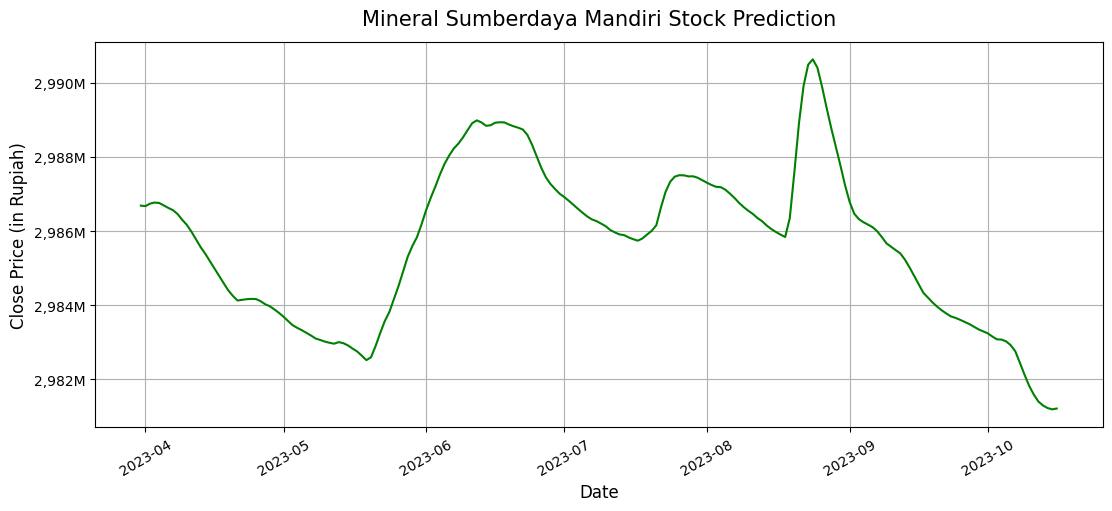

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 14s 302ms/step - loss: 0.0350 - val_loss: 0.0612
Epoch 2/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0139 - val_loss: 0.0609
Epoch 3/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0139 - val_loss: 0.0599
Epoch 4/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0138 - val_loss: 0.0563
Epoch 5/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0138 - val_loss: 0.0612
Epoch 6/10
24/24 [==============================] - 6s 271ms/step - loss: 0.0138 - val_loss: 0.0585
Epoch 7/10
24/24 [==============================] - 6s 259ms/step - loss: 0.0138 - val_loss: 0.0567
Epoch 8/10
24/24 [==============================] - 7s 272ms/step - loss: 0.0137 - val_loss: 0.0565
Epoch 9/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0137 - val_loss: 0.0601
Epoch 10/10
24/24 [==============================] - 6s 270ms/step - loss: 0.0136 - val_loss: 0.057

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 33ms/step
Mean Absolute Error (MAE): 0.04749
Mean Absolute Percentage Error (MAPE): 0.30498
Root Mean Squared Error (RMSE): 0.05147
Mean Squared Error (MSE): 0.0026493
R-Squared (R2): -5.477542
T-Statistic 0.7088
P-Value 4.2619934993343495e-20
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 33ms/step


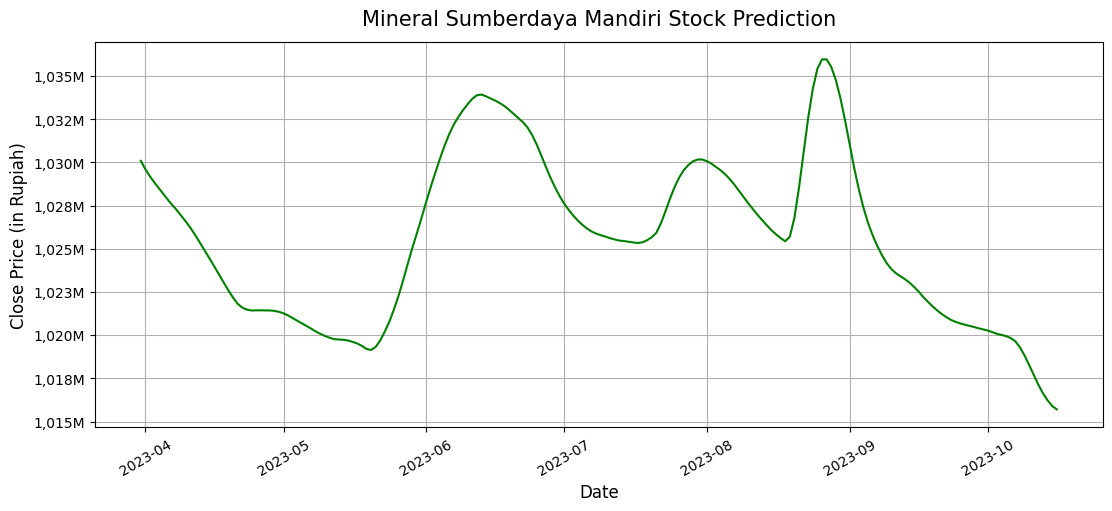

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 16s 347ms/step - loss: 0.0546 - val_loss: 0.0232
Epoch 2/10
24/24 [==============================] - 7s 281ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 3/10
24/24 [==============================] - 7s 280ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 4/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 5/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 6/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 7/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 8/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 9/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 10/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0025 - val_loss: 0.004

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 36ms/step
Mean Absolute Error (MAE): 0.0148628
Mean Absolute Percentage Error (MAPE): 0.10013
Root Mean Squared Error (RMSE): 0.02399
Mean Squared Error (MSE): 0.0005757
R-Squared (R2): -0.407622
T-Statistic 0.7106
P-Value 4.864286967788937e-20
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 37ms/step


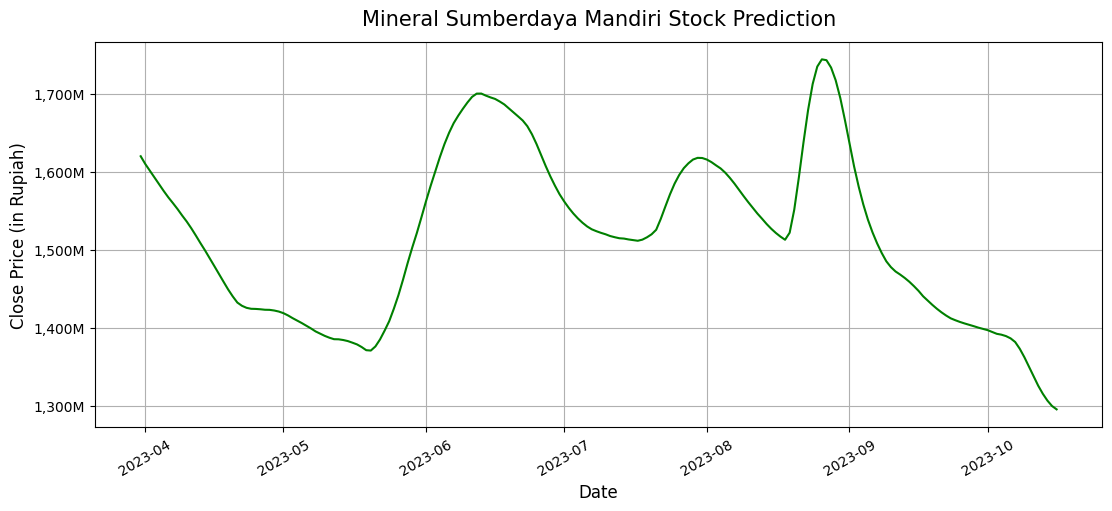

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 15s 323ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 2/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 3/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 6s 240ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 6s 258ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 6s 236ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 6s 237ms/step - loss: 9.8020e-04 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 6s 241ms/step - loss: 9.4722e-04 - val_loss: 0.0025
Epoch 9/10
24/24 [==============================] - 6s 245ms/step - loss: 9.0374e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 6s 241ms/step - loss: 7.6732e-04 -

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 31ms/step
Mean Absolute Error (MAE): 0.0111669
Mean Absolute Percentage Error (MAPE): 0.07148
Root Mean Squared Error (RMSE): 0.01587
Mean Squared Error (MSE): 0.000252
R-Squared (R2): 0.383939
T-Statistic 0.8886
P-Value 3.0863430301036887e-12
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 31ms/step


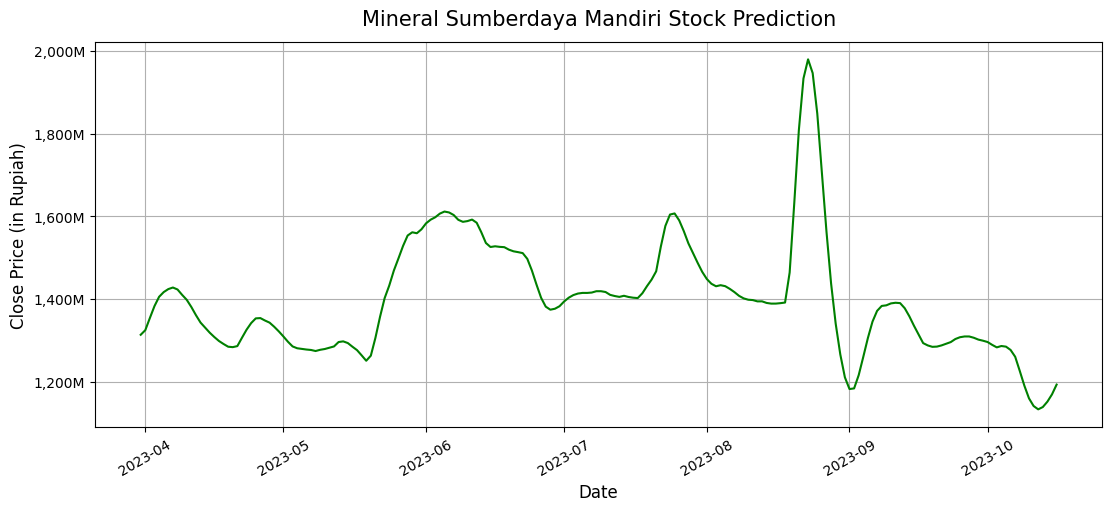

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 14s 322ms/step - loss: 0.0166 - val_loss: 0.0677
Epoch 2/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0135 - val_loss: 0.0573
Epoch 3/10
24/24 [==============================] - 7s 275ms/step - loss: 0.0129 - val_loss: 0.0545
Epoch 4/10
24/24 [==============================] - 7s 311ms/step - loss: 0.0125 - val_loss: 0.0532
Epoch 5/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0126 - val_loss: 0.0512
Epoch 6/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0119 - val_loss: 0.0505
Epoch 7/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0120 - val_loss: 0.0488
Epoch 8/10
24/24 [==============================] - 7s 290ms/step - loss: 0.0115 - val_loss: 0.0481
Epoch 9/10
24/24 [==============================] - 7s 285ms/step - loss: 0.0112 - val_loss: 0.0467
Epoch 10/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0110 - val_loss: 0.044

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 31ms/step
Mean Absolute Error (MAE): 0.0409649
Mean Absolute Percentage Error (MAPE): 0.2621
Root Mean Squared Error (RMSE): 0.04495
Mean Squared Error (MSE): 0.0020202
R-Squared (R2): -3.939365
T-Statistic 0.7266
P-Value 1.6188066759330534e-19
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 31ms/step


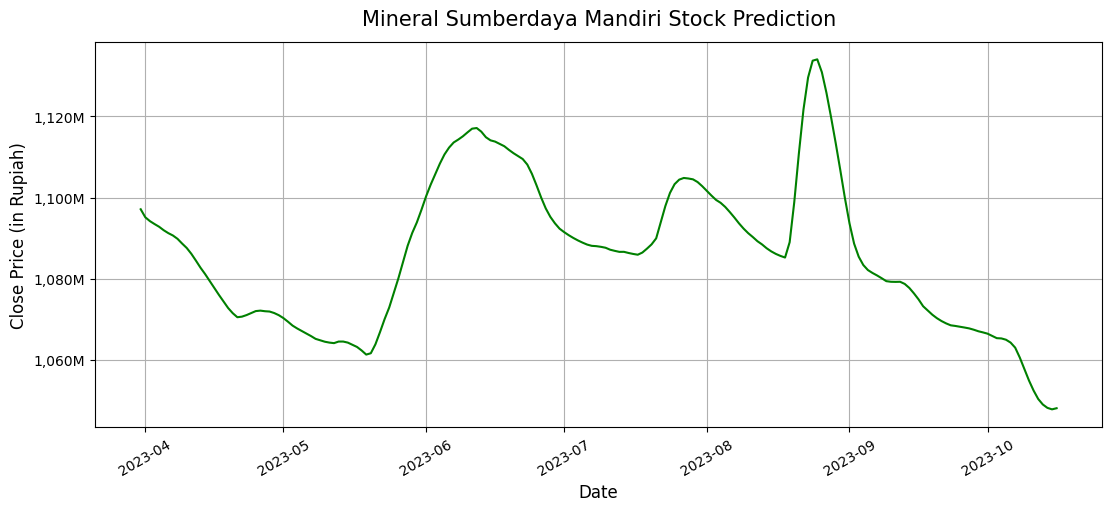

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 15s 306ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 2/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 3/10
24/24 [==============================] - 6s 247ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 6/10
24/24 [==============================] - 6s 255ms/step - loss: 9.5687e-04 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 6s 250ms/step - loss: 8.8385e-04 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 6s 262ms/step - loss: 8.8161e-04 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 7s 274ms/step - loss: 8.5582e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 7s 280ms/step - loss: 7.7917e-

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 31ms/step
Mean Absolute Error (MAE): 0.0081723
Mean Absolute Percentage Error (MAPE): 0.05135
Root Mean Squared Error (RMSE): 0.01439
Mean Squared Error (MSE): 0.0002072
R-Squared (R2): 0.493369
T-Statistic 0.8944
P-Value 7.24486356323828e-12
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 33ms/step


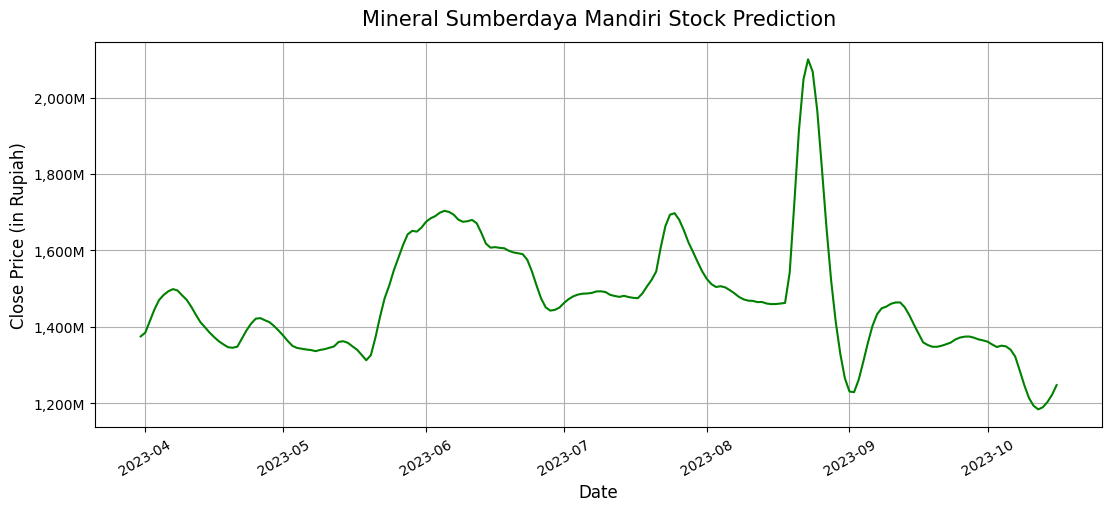

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 17s 363ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 2/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0025 - val_loss: 0.0123
Epoch 3/10
24/24 [==============================] - 7s 294ms/step - loss: 0.0023 - val_loss: 0.0045
Epoch 4/10
24/24 [==============================] - 7s 290ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 7s 287ms/step - loss: 0.0019 - val_loss: 0.0061
Epoch 6/10
24/24 [==============================] - 7s 305ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 7/10
24/24 [==============================] - 8s 351ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 8/10
24/24 [==============================] - 8s 335ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 8s 340ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 10/10
24/24 [==============================] - 8s 316ms/step - loss: 0.0013 - val_loss: 0.002

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 0.0155833
Mean Absolute Percentage Error (MAPE): 0.10365
Root Mean Squared Error (RMSE): 0.02019
Mean Squared Error (MSE): 0.0004076
R-Squared (R2): 0.003515
T-Statistic 0.874
P-Value 3.96046395548591e-13
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 35ms/step


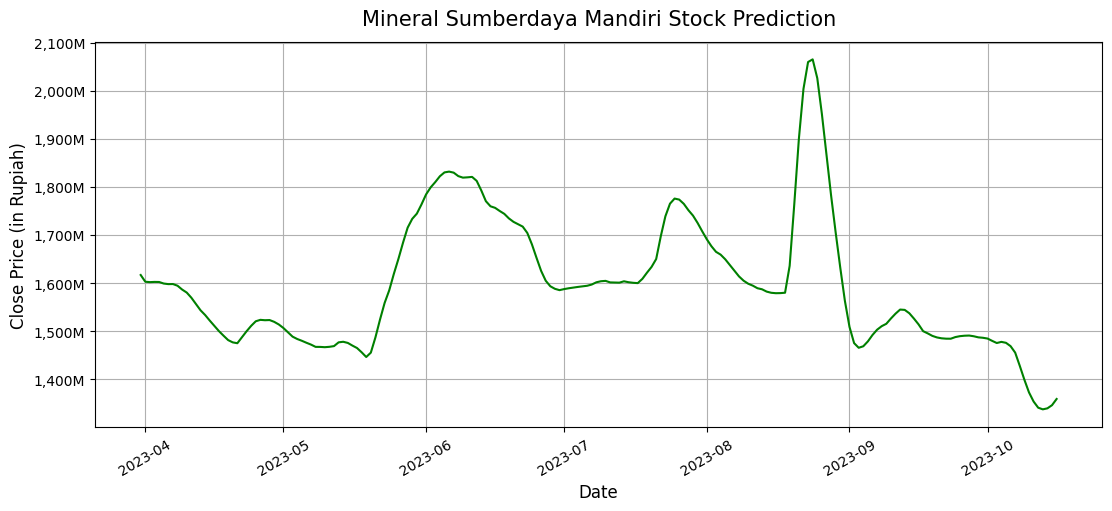

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 16s 332ms/step - loss: 0.0261 - val_loss: 0.1240
Epoch 2/10
24/24 [==============================] - 6s 255ms/step - loss: 0.0261 - val_loss: 0.1223
Epoch 3/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0252 - val_loss: 0.1205
Epoch 4/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0247 - val_loss: 0.1188
Epoch 5/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0243 - val_loss: 0.1170
Epoch 6/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0240 - val_loss: 0.1153
Epoch 7/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0235 - val_loss: 0.1136
Epoch 8/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0233 - val_loss: 0.1119
Epoch 9/10
24/24 [==============================] - 6s 254ms/step - loss: 0.0229 - val_loss: 0.1102
Epoch 10/10
24/24 [==============================] - 6s 260ms/step - loss: 0.0222 - val_loss: 0.108

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 38ms/step
Mean Absolute Error (MAE): 0.1346421
Mean Absolute Percentage Error (MAPE): 0.8936
Root Mean Squared Error (RMSE): 0.13626
Mean Squared Error (MSE): 0.0185658
R-Squared (R2): -44.393461
T-Statistic 0.7634
P-Value 3.2140464592265882e-18
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 35ms/step


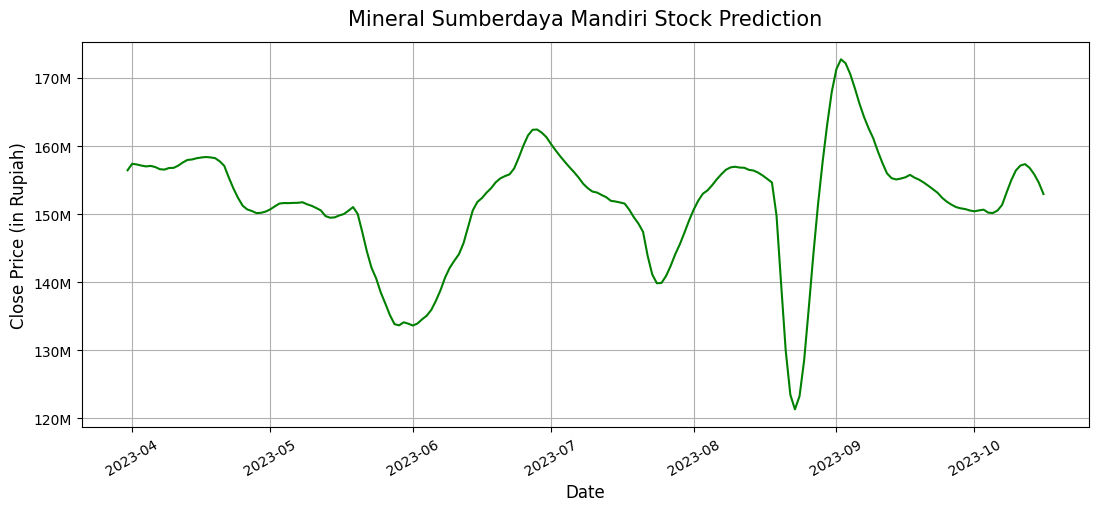

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 14s 303ms/step - loss: 0.0190 - val_loss: 0.0721
Epoch 2/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0159 - val_loss: 0.0673
Epoch 3/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0152 - val_loss: 0.0628
Epoch 4/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0144 - val_loss: 0.0586
Epoch 5/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0139 - val_loss: 0.0558
Epoch 6/10
24/24 [==============================] - 6s 270ms/step - loss: 0.0132 - val_loss: 0.0535
Epoch 7/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0125 - val_loss: 0.0517
Epoch 8/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0118 - val_loss: 0.0513
Epoch 9/10
24/24 [==============================] - 7s 308ms/step - loss: 0.0115 - val_loss: 0.0480
Epoch 10/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0110 - val_loss: 0.044

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 33ms/step
Mean Absolute Error (MAE): 0.0417912
Mean Absolute Percentage Error (MAPE): 0.2676
Root Mean Squared Error (RMSE): 0.04574
Mean Squared Error (MSE): 0.0020925
R-Squared (R2): -4.116259
T-Statistic 0.7084
P-Value 4.127701696238646e-20
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 33ms/step


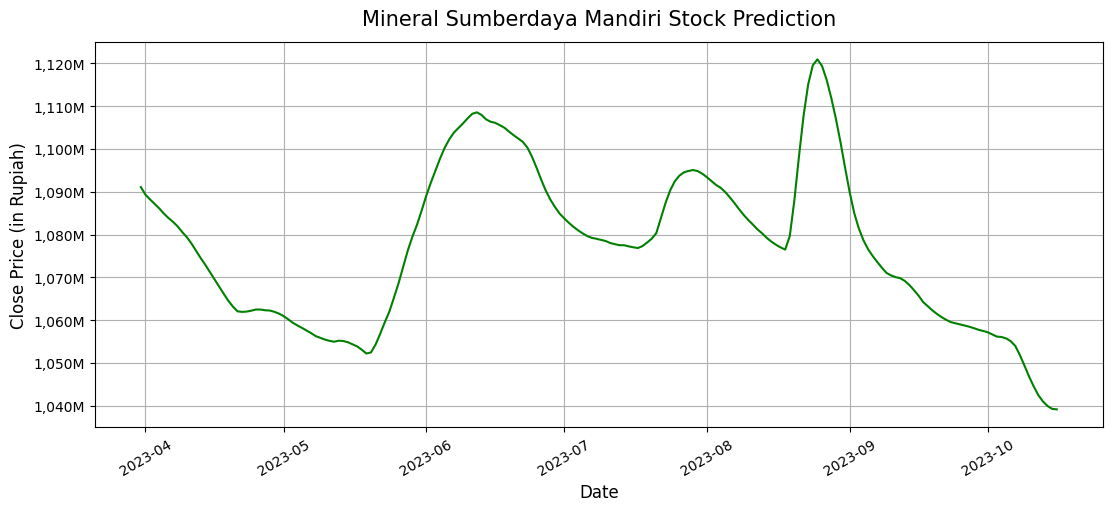

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [ ]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/aksi_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 13s 286ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 2/10
24/24 [==============================] - 5s 227ms/step - loss: 0.0021 - val_loss: 0.0038
Epoch 3/10
24/24 [==============================] - 6s 232ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 6s 248ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 6/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 7/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 6s 243ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 10/10
24/24 [==============================] - 6s 242ms/step - loss: 0.0011 - val_loss: 0.003

In [ ]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 30ms/step
Mean Absolute Error (MAE): 0.0097267
Mean Absolute Percentage Error (MAPE): 0.06188
Root Mean Squared Error (RMSE): 0.0171
Mean Squared Error (MSE): 0.0002925
R-Squared (R2): 0.284947
T-Statistic 0.8819
P-Value 1.1724668545071149e-12
Elapsed Time (min): 9.8
Skew distribution


7/7 [==============================] - 0s 31ms/step


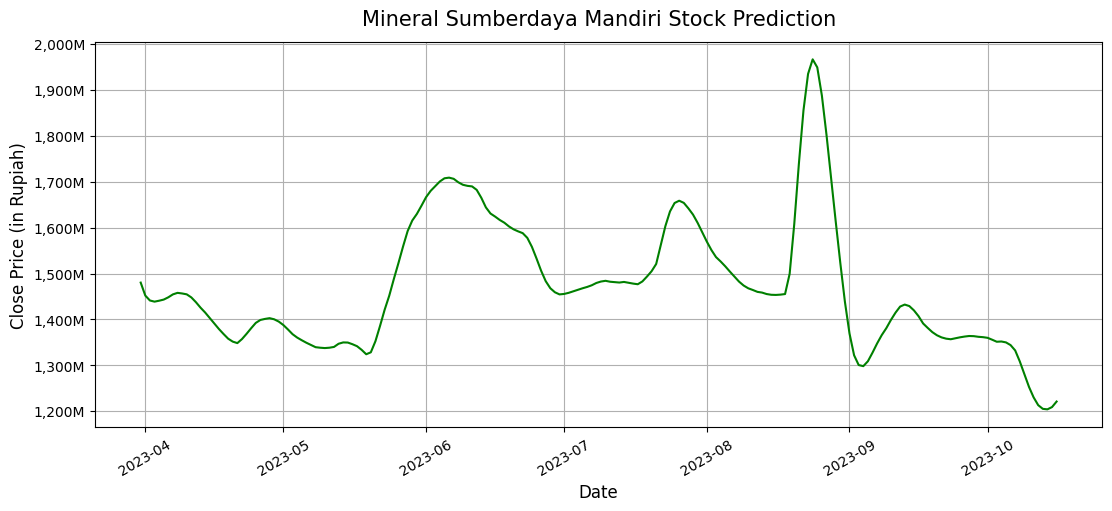

In [ ]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [ ]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 30ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 33ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 36ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 38ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 37ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 38ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 31ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 35ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 37ms/step
Training

In [ ]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                87.93  0.14219   0.94529  0.02063   
           adagrad                 73.07  0.04137   0.26488  0.00205   
           adam                    58.30  0.01033   0.06585  0.00023   
           adamax                  84.57  0.01024   0.06506  0.00028   
           nadam                   88.61  0.00852   0.05428  0.00020   
           rmsprop                 88.30  0.01053   0.06702  0.00029   
           sgd                     90.75  0.03958   0.25353  0.00189   
relu       adadelta               130.13  0.14307   0.95101  0.02089   
           adagrad                 87.68  0.03987   0.25505  0.00192   
           adam                    86.25  0.01016   0.06563  0.00024   
           adamax                 142.57  0.02337   0.15777  0.00081   
           nadam                  140.67  0.00813   0.05111  0.00021   
           rmsprop                131.07  0.03230   0.21847  0.00124   
           sgd                    134.50  0.03380   0.21657  0.00141   
sigmoid    adadelta               109.25  1.10206   7.43929  1.21493   
           adagrad                126.42  0.06545   0.42630  0.00469   
           adam                   118.22  0.02042   0.13886  0.00068   
           adamax                 121.02  0.01262   0.08188  0.00048   
           nadam                  130.46  0.01917   0.13009  0.00058   
           rmsprop                129.64  0.02439   0.16845  0.00086   
           sgd                    101.64  0.04048   0.25821  0.00200   
tanh       adadelta               132.48  0.12618   0.83729  0.01632   
           adagrad                105.04  0.03576   0.22845  0.00158   
           adam                   129.63  0.01785   0.11747  0.00047   
           adamax                 134.11  0.01607   0.10624  0.00048   
           nadam                  128.74  0.00966   0.06156  0.00022   
           rmsprop                118.23  0.02804   0.18531  0.00100   
           sgd                    125.99  0.02701   0.17317  0.00096   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   2.752517e-22         -49.45   0.14363     0.633783  
           adagrad    7.882358e-18          -4.02   0.04528     0.773676  
           adam       5.025312e-12           0.44   0.01517     0.891929  
           adamax     1.019564e-12           0.30   0.01673     0.880877  
           nadam      1.796780e-12           0.50   0.01414     0.884886  
           rmsprop    2.690909e-13           0.30   0.01703     0.871076  
           sgd        7.327646e-20          -3.62   0.04347     0.716119  
relu       adadelta   2.490810e-14         -50.08   0.14453     0.852201  
           adagrad    1.248875e-20          -3.70   0.04382     0.691731  
           adam       4.196216e-12           0.41   0.01549     0.890716  
           adamax     4.014429e-14          -0.97   0.02846     0.856131  
           nadam      4.678218e-12           0.49   0.01449     0.891449  
           rmsprop    1.029692e-13          -2.03   0.03521     0.863672  
           sgd        1.489069e-20          -2.44   0.03755     0.694224  
sigmoid    adadelta   1.681744e-20       -2969.52   1.10224     0.695939  
           adagrad    6.442912e-22         -10.47   0.06848     0.647364  
           adam       5.129273e-17          -0.67   0.02608     0.794112  
           adamax     4.709583e-16          -0.17   0.02191     0.816529  
           nadam      2.338917e-15          -0.42   0.02408     0.831598  
           rmsprop    9.491926e-18          -1.10   0.02933     0.775767  
           sgd        4.823235e-20          -3.90   0.04472     0.710491  
tanh       adadelta   3.822818e-22         -38.89   0.12775     0.639075  
           adagrad    1.284196e-19          -2.86   0.03975  

In [ ]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
relu       nadam                  140.67  0.00813   0.05111  0.00021   
linear     nadam                   88.61  0.00852   0.05428  0.00020   
tanh       nadam                  128.74  0.00966   0.06156  0.00022   
linear     adamax                  84.57  0.01024   0.06506  0.00028   
relu       adam                    86.25  0.01016   0.06563  0.00024   
linear     adam                    58.30  0.01033   0.06585  0.00023   
           rmsprop                 88.30  0.01053   0.06702  0.00029   
sigmoid    adamax                 121.02  0.01262   0.08188  0.00048   
tanh       adamax                 134.11  0.01607   0.10624  0.00048   
           adam                   129.63  0.01785   0.11747  0.00047   
sigmoid    nadam                  130.46  0.01917   0.13009  0.00058   
           adam                   118.22  0.02042   0.13886  0.00068   
relu       adamax                 142.57  0.02337   0.15777  0.00081   
sigmoid    rmsprop                129.64  0.02439   0.16845  0.00086   
tanh       sgd                    125.99  0.02701   0.17317  0.00096   
           rmsprop                118.23  0.02804   0.18531  0.00100   
relu       sgd                    134.50  0.03380   0.21657  0.00141   
           rmsprop                131.07  0.03230   0.21847  0.00124   
tanh       adagrad                105.04  0.03576   0.22845  0.00158   
linear     sgd                     90.75  0.03958   0.25353  0.00189   
relu       adagrad                 87.68  0.03987   0.25505  0.00192   
sigmoid    sgd                    101.64  0.04048   0.25821  0.00200   
linear     adagrad                 73.07  0.04137   0.26488  0.00205   
sigmoid    adagrad                126.42  0.06545   0.42630  0.00469   
tanh       adadelta               132.48  0.12618   0.83729  0.01632   
linear     adadelta                87.93  0.14219   0.94529  0.02063   
relu       adadelta               130.13  0.14307   0.95101  0.02089   
sigmoid    adadelta               109.25  1.10206   7.43929  1.21493   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
relu       nadam      4.678218e-12           0.49   0.01449     0.891449  
linear     nadam      1.796780e-12           0.50   0.01414     0.884886  
tanh       nadam      6.534199e-12           0.46   0.01483     0.893680  
linear     adamax     1.019564e-12           0.30   0.01673     0.880877  
relu       adam       4.196216e-12           0.41   0.01549     0.890716  
linear     adam       5.025312e-12           0.44   0.01517     0.891929  
           rmsprop    2.690909e-13           0.30   0.01703     0.871076  
sigmoid    adamax     4.709583e-16          -0.17   0.02191     0.816529  
tanh       adamax     5.501822e-14          -0.17   0.02191     0.858686  
           adam       2.189352e-12          -0.15   0.02168     0.886263  
sigmoid    nadam      2.338917e-15          -0.42   0.02408     0.831598  
           adam       5.129273e-17          -0.67   0.02608     0.794112  
relu       adamax     4.014429e-14          -0.97   0.02846     0.856131  
sigmoid    rmsprop    9.491926e-18          -1.10   0.02933     0.775767  
tanh       sgd        6.813648e-20          -1.34   0.03098     0.715146  
           rmsprop    8.993734e-13          -1.45   0.03162     0.879976  
relu       sgd        1.489069e-20          -2.44   0.03755     0.694224  
           rmsprop    1.029692e-13          -2.03   0.03521     0.863672  
tanh       adagrad    1.284196e-19          -2.86   0.03975     0.723541  
linear     sgd        7.327646e-20          -3.62   0.04347     0.716119  
relu       adagrad    1.248875e-20          -3.70   0.04382     0.691731  
sigmoid    sgd        4.823235e-20          -3.90   0.04472     0.710491  
linear     adagrad    7.882358e-18          -4.02   0.04528  

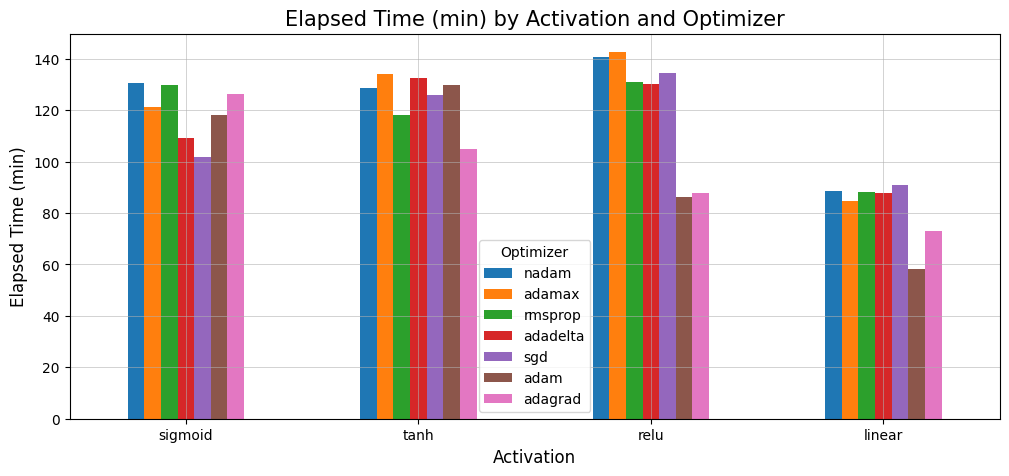

In [ ]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

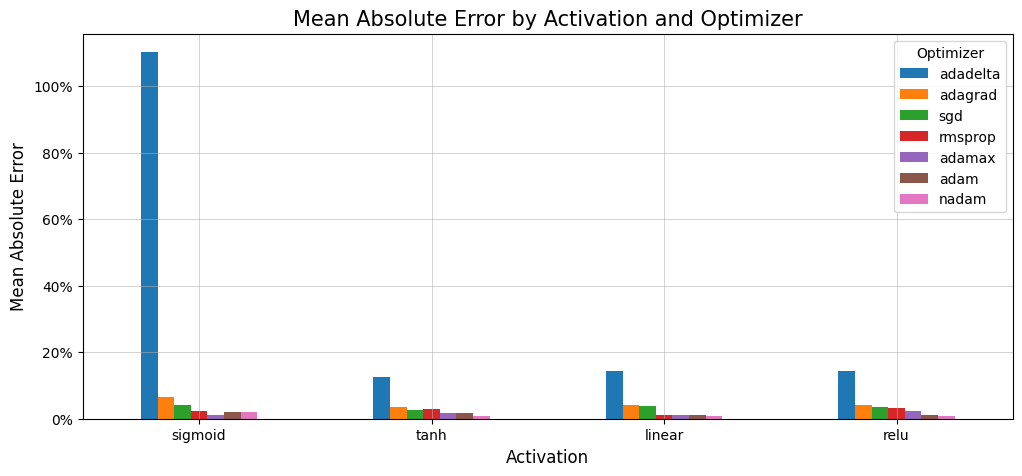

In [ ]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

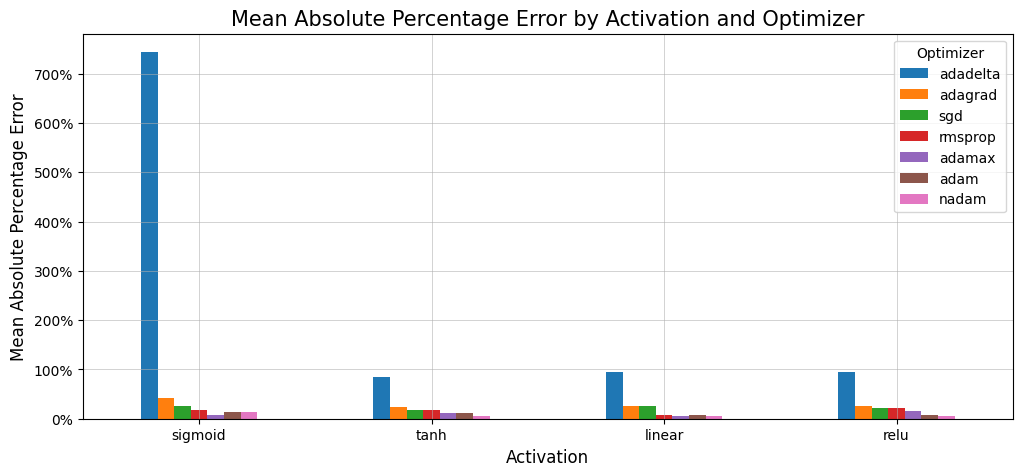

In [ ]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

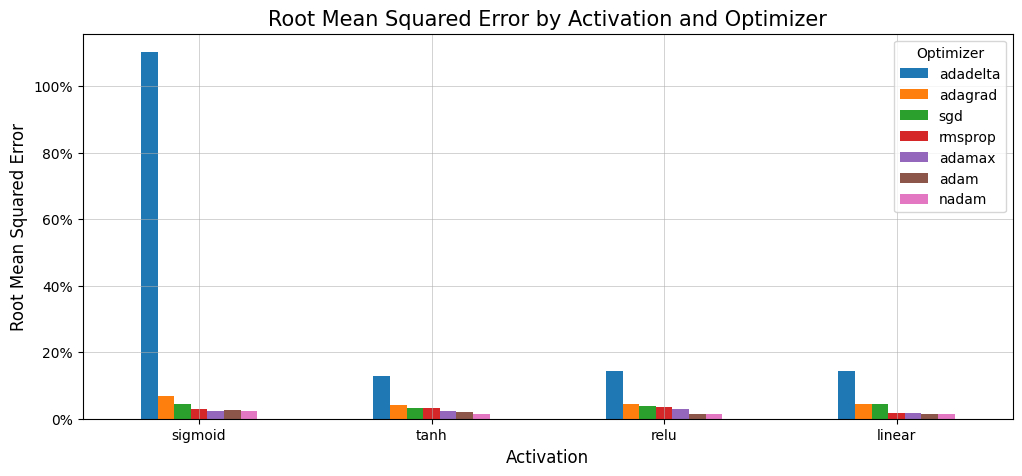

In [ ]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

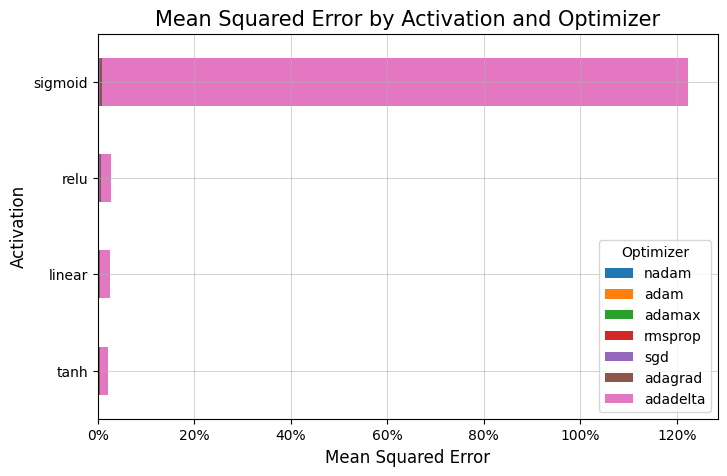

In [ ]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=True)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='barh', stacked=True, ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

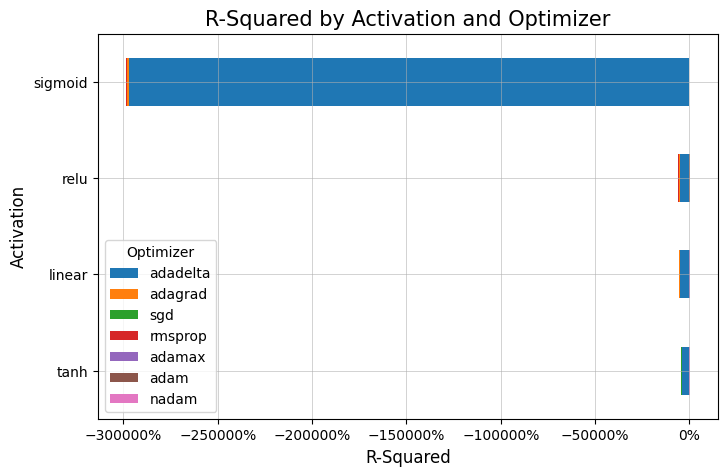

In [ ]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', stacked=True, ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()